In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt


df = pd.read_csv("Stage1.csv")

In [2]:
df.columns

Index(['Unnamed: 0', 'site', 'date', 'time', 'aod_440', 'aod_675', 'aod_870',
       'aod_1020', 'eae_440_870', 'ssa_440', 'ssa_675', 'ssa_870', 'ssa_1020',
       'g_440', 'g_675', 'g_870', 'g_1020', 'ri_real_440', 'ri_real_675',
       'ri_real_870', 'ri_real_1020', 'ri_imag_440', 'ri_imag_675',
       'ri_imag_870', 'ri_imag_1020', 'REff-F', 'Std-F', 'REff-C', 'Std-C',
       'REff-F^2', 'REff-C^2', 'Std-F^2', 'Std-C^2', 'Vol-Con_Fine',
       'Vol-Con_Coarse', 'gamma', 'latitude', 'longitude', 'datetime',
       'Solar_Zenith_Angle'],
      dtype='object')

In [6]:
df_clean = df[['ssa_440', 'eae_440_870']].dropna()
X = df_clean.values

In [10]:
bandwidth = estimate_bandwidth(X, quantile=0.05)

In [11]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

In [12]:
n_clusters = len(np.unique(labels))
print(f"Number of clusters: {n_clusters}")
print("Cluster Centers (SSA, EAE):\n", cluster_centers)


Number of clusters: 5
Cluster Centers (SSA, EAE):
 [[0.91075543 0.15223673]
 [0.91871953 1.34326586]
 [0.88831393 0.78376666]
 [0.92952271 1.75765791]
 [0.94268421 2.270123  ]]


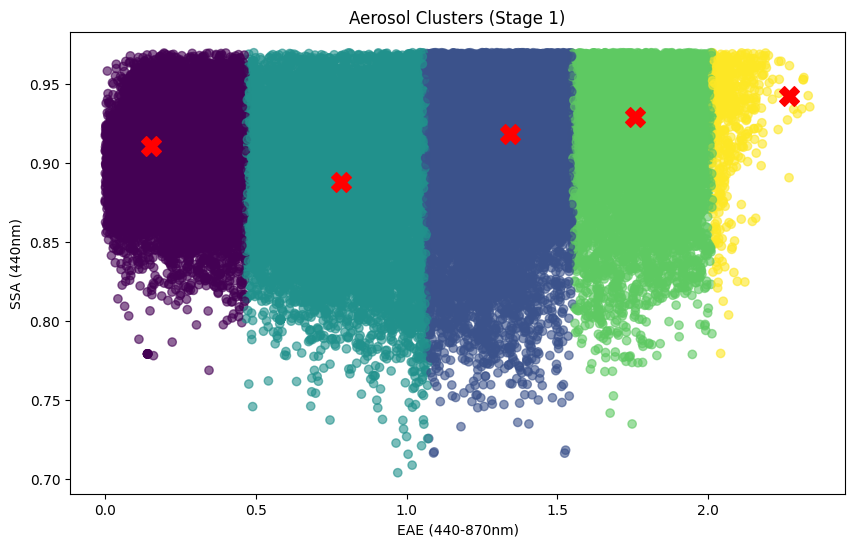

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,1], X[:,0], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(cluster_centers[:,1], cluster_centers[:,0], c='red', marker='X', s=200)
plt.xlabel('EAE (440-870nm)')
plt.ylabel('SSA (440nm)')
plt.title('Aerosol Clusters (Stage 1)')
plt.show()


In [63]:
df['AAE_440_870'] = -np.log(df['aod_440']/df['aod_870']) / np.log(440/870)


def refine_clusters(row):
    ssa = row['ssa_440']
    eae = row['eae_440_870']
    
    # Dust (EAE 0.1-0.3, SSA 0.89-0.94)
    if (0.1 <= eae <= 0.3) and (0.89 <= ssa <= 0.94):
        return 'Dust'
    
    # Mixed-Coarse (EAE ≤0.8)
    elif eae <= 0.8:
        return 'Mixed-Coarse'
    
    # Urban/Industrial (EAE 1.5-1.8, SSA ≥0.94)
    elif (1.5 <= eae <= 1.8) and (ssa >= 0.94):
        return 'Urban/Industrial'
    
    # Biomass Burning (SSA 0.87-0.94)
    elif 0.87 <= ssa < 0.94 and (row['AAE_440_870'] > 1.5):
        return 'Biomass Burning'
    
    # Mixed-Fine (remaining cases with EAE >0.8)
    else:
        return 'Mixed-Fine'


df['aerosol_type'] = df.apply(refine_clusters, axis=1)


In [64]:
df['aerosol_type'].unique()

array(['Biomass Burning', 'Mixed-Fine', 'Urban/Industrial', 'Dust',
       'Mixed-Coarse'], dtype=object)

In [65]:
# Paper's CRI baselines (Table 4)
cri_baseline = {
    'Dust': {'imag_440': 0.003396},
    'Urban/Industrial': {'imag_440': 0.004315},
    'Biomass Burning': {'imag_440': 0.01828}
}

# Validate clusters
for aerosol_type in ['Dust', 'Urban/Industrial', 'Biomass Burning']:
    cluster_data = df[df['aerosol_type'] == aerosol_type]
    median_imag = cluster_data['ri_imag_440'].median()
    expected = cri_baseline[aerosol_type]['imag_440']
    print(f"{aerosol_type}: Observed={median_imag:.5f}, Expected={expected:.5f}")


Dust: Observed=0.00338, Expected=0.00340
Urban/Industrial: Observed=0.00596, Expected=0.00432
Biomass Burning: Observed=0.01392, Expected=0.01828


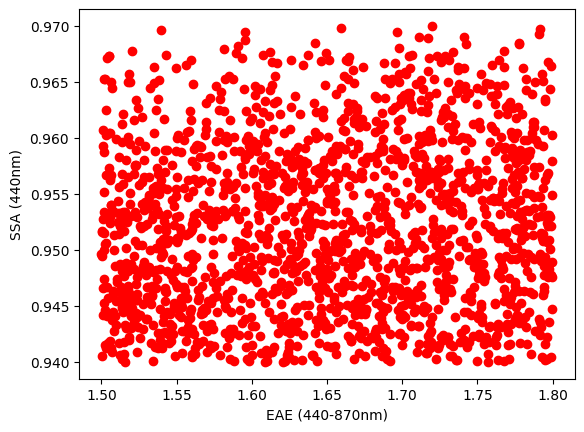

In [66]:
# Suspect U/I points
ui_outliers = df[(df['aerosol_type'] == 'Urban/Industrial') & 
                (df['ri_imag_440'] > 0.005)]

# Plot their SSA vs EAE
plt.scatter(ui_outliers['eae_440_870'], ui_outliers['ssa_440'], c='red')
plt.xlabel('EAE (440-870nm)')
plt.ylabel('SSA (440nm)')
plt.show()


In [67]:
def refine_ui_outliers(row):
    if row['aerosol_type'] == 'Urban/Industrial':
        if row['ri_imag_440'] > 0.007:
            return 'Biomass Burning'
        elif row['ri_imag_440'] > 0.0035:
            return 'Mixed-Fine'
        else:
            return 'Urban/Industrial'
    else:
        return row['aerosol_type']

df['aerosol_type_refined'] = df.apply(refine_ui_outliers, axis=1)


In [68]:
# Paper's CRI baselines (Table 4)
cri_baseline = {
    'Dust': {'imag_440': 0.003396},
    'Urban/Industrial': {'imag_440': 0.004315},
    'Biomass Burning': {'imag_440': 0.01828}
}

# Validate clusters
for aerosol_type in ['Dust', 'Urban/Industrial', 'Biomass Burning']:
    cluster_data = df[df['aerosol_type_refined'] == aerosol_type]
    median_imag = cluster_data['ri_imag_440'].median()
    expected = cri_baseline[aerosol_type]['imag_440']
    print(f"{aerosol_type}: Observed={median_imag:.5f}, Expected={expected:.5f}")


Dust: Observed=0.00338, Expected=0.00340
Urban/Industrial: Observed=0.00314, Expected=0.00432
Biomass Burning: Observed=0.01294, Expected=0.01828


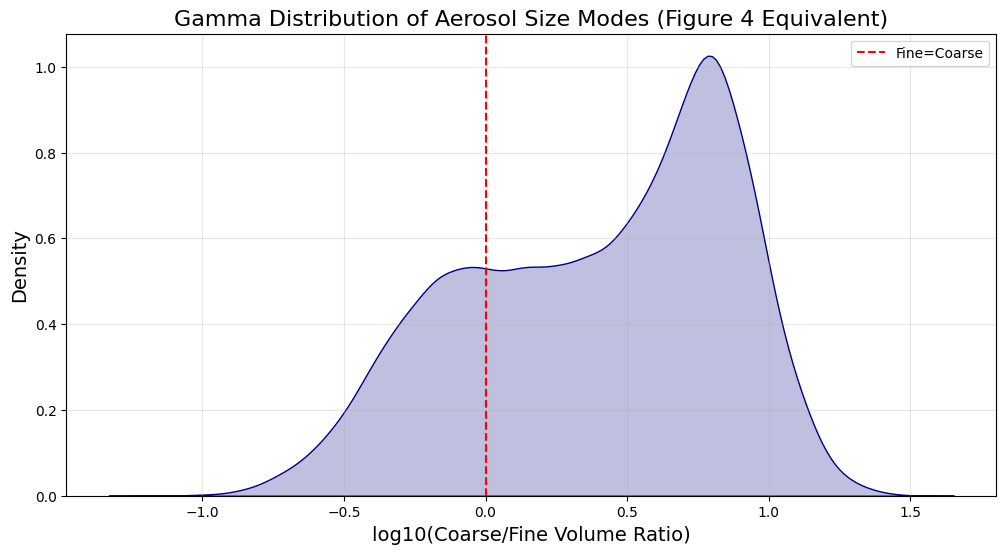

In [71]:
plt.figure(figsize=(12,6))
sns.kdeplot(np.log10(df['gamma']), fill=True, color='navy')

plt.axvline(np.log10(1), color='r', ls='--', label='Fine=Coarse')
plt.xlabel('log10(Coarse/Fine Volume Ratio)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Gamma Distribution of Aerosol Size Modes (Figure 4 Equivalent)', fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

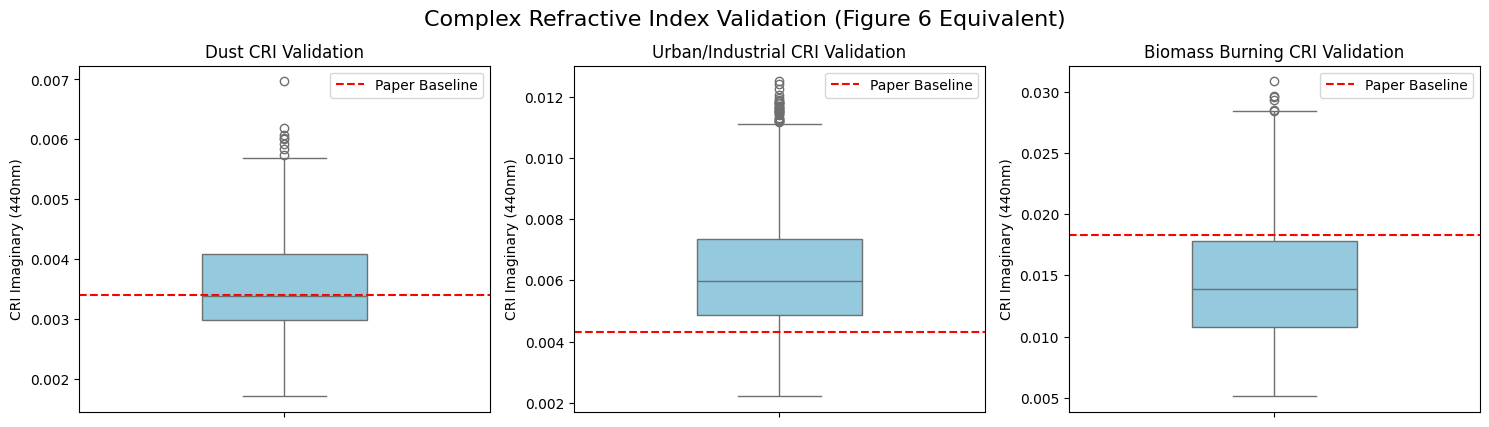

In [84]:
cri_baseline = {
    'Dust': 0.003396,
    'Urban/Industrial': 0.004315,
    'Biomass Burning': 0.01828
}

plt.figure(figsize=(15,8))

# Create subplots
for i, (aerosol_type, ref_value) in enumerate(cri_baseline.items(), 1):
    plt.subplot(2,3,i)
    data = df[df['aerosol_type'] == aerosol_type]['ri_imag_440']
    
    sns.boxplot(data=data, color='skyblue', width=0.4)
    plt.axhline(ref_value, color='r', ls='--', label='Paper Baseline')
    
    plt.title(f'{aerosol_type} CRI Validation', fontsize=12)
    plt.ylabel('CRI Imaginary (440nm)', fontsize=10)
    plt.legend()

plt.suptitle('Complex Refractive Index Validation (Figure 6 Equivalent)', fontsize=16)
plt.tight_layout()
plt.show()


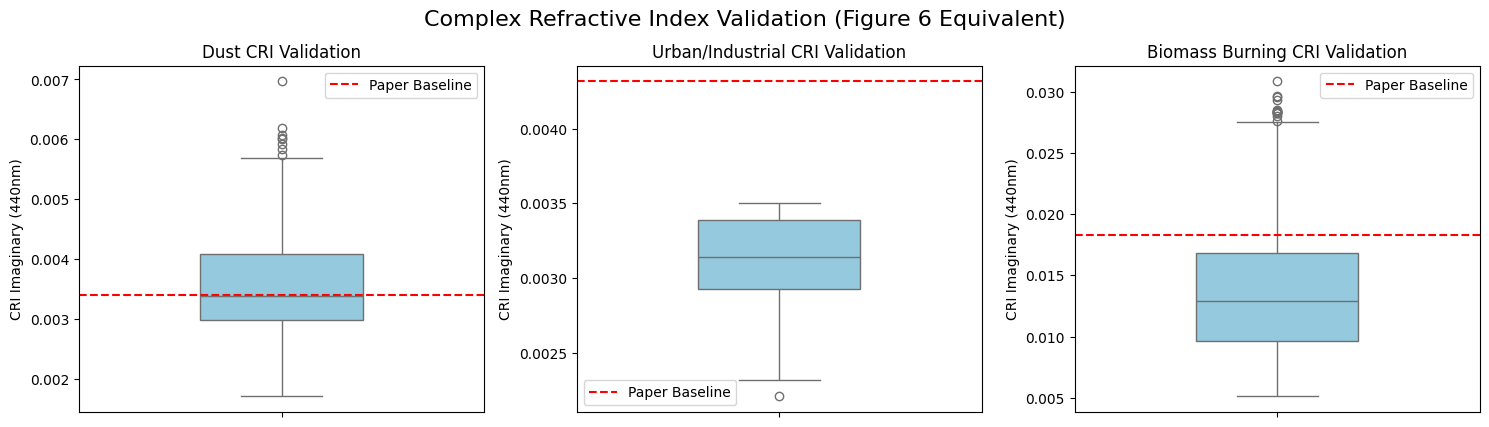

In [87]:
cri_baseline = {
    'Dust': 0.003396,
    'Urban/Industrial': 0.004315,
    'Biomass Burning': 0.01828
}

plt.figure(figsize=(15,8))

# Create subplots
for i, (aerosol_type, ref_value) in enumerate(cri_baseline.items(), 1):
    plt.subplot(2,3,i)
    data = df[df['aerosol_type_refined'] == aerosol_type]['ri_imag_440']
    
    sns.boxplot(data=data, color='skyblue', width=0.4)
    plt.axhline(ref_value, color='r', ls='--', label='Paper Baseline')
    
    plt.title(f'{aerosol_type} CRI Validation', fontsize=12)
    plt.ylabel('CRI Imaginary (440nm)', fontsize=10)
    plt.legend()

plt.suptitle('Complex Refractive Index Validation (Figure 6 Equivalent)', fontsize=16)
plt.tight_layout()
plt.show()


In [85]:
print(df['aerosol_type'].value_counts())


aerosol_type
Mixed-Fine          25739
Mixed-Coarse        21783
Dust                 9992
Biomass Burning      4791
Urban/Industrial     2380
Name: count, dtype: int64


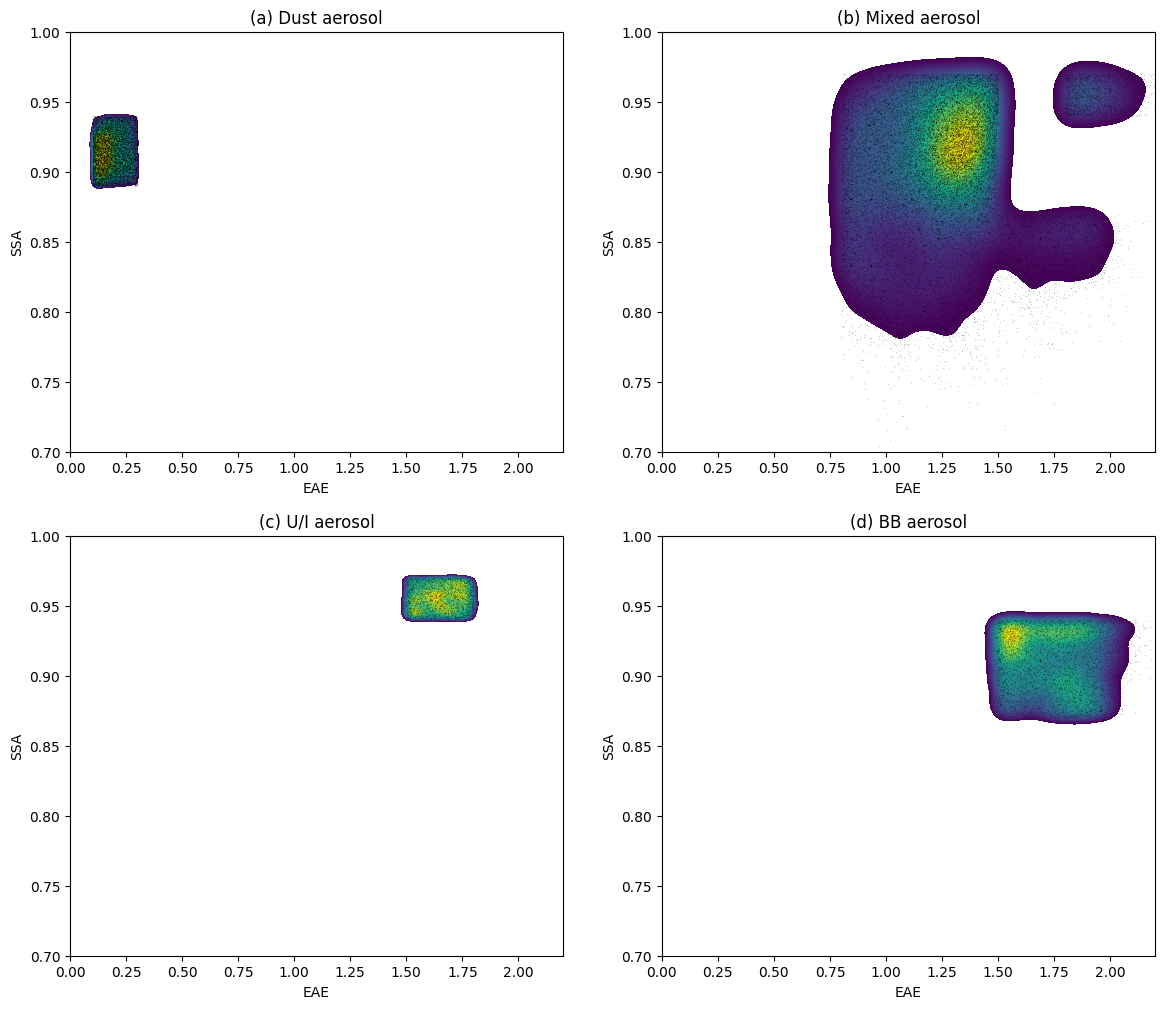

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the aerosol types and their subplot labels
aerosol_types = [
    ('Dust', 'Dust aerosol'),
    ('Mixed-Fine', 'Mixed aerosol'),
    ('Urban/Industrial', 'U/I aerosol'),
    ('Biomass Burning', 'BB aerosol')
]

plt.figure(figsize=(14, 12))

for i, (atype, label) in enumerate(aerosol_types, 1):
    plt.subplot(2, 2, i)
    subset = df[df['aerosol_type'] == atype]
    # Use kdeplot for density, similar to the paper
    sns.kdeplot(
        x=subset['eae_440_870'],
        y=subset['ssa_440'],
        cmap="viridis",         # Same as paper
        fill=True,
        thresh=0.05,
        bw_adjust=1.0,      # Try different smoothing levels (0.5-1.0)
        levels=60           # More levels create smoother gradients
)
    # Modify these scatter parameters
    plt.scatter(subset['eae_440_870'], subset['ssa_440'], 
            s=3,           # Make points smaller (0.5 instead of 1)
            alpha=0.2,       # Make more transparent (0.05 instead of 0.1)
            color='k',        # Keep black color
            marker='.',       # Use dot marker
            linewidths=0)     # Remove point outlines
  # Add points for context
    plt.xlabel("EAE")
    plt.ylabel("SSA")
    plt.title(f"({chr(96+i)}) {label}")
    plt.xlim(0, 2.2)
    plt.ylim(0.7, 1.0)

plt.show()


In [117]:
import seaborn as sns
from scipy import stats

def validate_clusters(df):
    # Expected ranges from paper (Table 2)
    expected_ranges = {
        'Dust': {'EAE': (0.1, 0.3), 'SSA': (0.89, 0.94)},
        'Urban/Industrial': {'EAE': (1.5, 1.8), 'SSA': (0.94, 0.97)},
        'Biomass Burning': {'SSA': (0.87, 0.94)},
        'Mixed-Coarse': {'EAE_MAX': 0.8},
        'Mixed-Fine': {'EAE_MIN': 0.8}
    }

    results = {}
    for aerosol_type in df['aerosol_type'].unique():
        subset = df[df['aerosol_type'] == aerosol_type]
        stats = {
            'EAE_median': subset['eae_440_870'].median(),
            'SSA_median': subset['ssa_440'].median(),
            'EAE_range': (subset['eae_440_870'].quantile(0.05), subset['eae_440_870'].quantile(0.95)),
            'SSA_range': (subset['ssa_440'].quantile(0.05), subset['ssa_440'].quantile(0.95))
        }
        results[aerosol_type] = stats
    
    print("Cluster Validation Results:")
    for k, v in results.items():
        print(f"\n{k}:")
        print(f"  EAE: {v['EAE_median']:.2f} (5-95%: {v['EAE_range'][0]:.2f}-{v['EAE_range'][1]:.2f})")
        print(f"  SSA: {v['SSA_median']:.2f} (5-95%: {v['SSA_range'][0]:.2f}-{v['SSA_range'][1]:.2f})")

In [118]:
validate_clusters(df)

Cluster Validation Results:

Biomass Burning:
  EAE: 1.74 (5-95%: 1.51-2.01)
  SSA: 0.91 (5-95%: 0.87-0.94)

Mixed-Fine:
  EAE: 1.27 (5-95%: 0.86-1.88)
  SSA: 0.91 (5-95%: 0.82-0.96)

Urban/Industrial:
  EAE: 1.65 (5-95%: 1.51-1.78)
  SSA: 0.96 (5-95%: 0.94-0.97)

Dust:
  EAE: 0.18 (5-95%: 0.11-0.29)
  SSA: 0.91 (5-95%: 0.89-0.94)

Mixed-Coarse:
  EAE: 0.40 (5-95%: 0.06-0.75)
  SSA: 0.90 (5-95%: 0.84-0.95)


In [119]:
def validate_cri(df):
    cri_baseline = {
        'Dust': {'real': 1.4584, 'imag': 0.003396},
        'Urban/Industrial': {'real': 1.4372, 'imag': 0.004315},
        'Biomass Burning': {'real': 1.5051, 'imag': 0.01828}
    }

    print("\nCRI Validation Results:")
    for aerosol_type in ['Dust', 'Urban/Industrial', 'Biomass Burning']:
        subset = df[df['aerosol_type'] == aerosol_type]
        real_med = subset['ri_real_440'].median()
        imag_med = subset['ri_imag_440'].median()
        
        print(f"\n{aerosol_type}:")
        print(f"  Real CRI: {real_med:.4f} (Expected: {cri_baseline[aerosol_type]['real']})")
        print(f"  Imag CRI: {imag_med:.5f} (Expected: {cri_baseline[aerosol_type]['imag']})")

In [120]:
validate_cri(df)


CRI Validation Results:

Dust:
  Real CRI: 1.4615 (Expected: 1.4584)
  Imag CRI: 0.00338 (Expected: 0.003396)

Urban/Industrial:
  Real CRI: 1.4458 (Expected: 1.4372)
  Imag CRI: 0.00596 (Expected: 0.004315)

Biomass Burning:
  Real CRI: 1.4846 (Expected: 1.5051)
  Imag CRI: 0.01392 (Expected: 0.01828)


In [123]:
def validate_optical_properties(df):
    print("\nOptical Property Ranges:")
    print("AOD_440:", df['aod_440'].describe(percentiles=[0.05, 0.95]))
    print("SSA_440:", df['ssa_440'].describe(percentiles=[0.05, 0.95]))
    print("EAE_440_870:", df['eae_440_870'].describe(percentiles=[0.05, 0.95]))
    print("AAE_440_870:", df['AAE_440_870'].describe(percentiles=[0.05, 0.95]))


In [124]:
validate_optical_properties(df)


Optical Property Ranges:
AOD_440: count    64685.000000
mean         0.751768
std          0.380500
min          0.400000
5%           0.419100
50%          0.626200
95%          1.515580
max          4.012500
Name: aod_440, dtype: float64
SSA_440: count    64685.000000
mean         0.904771
std          0.037434
min          0.703800
5%           0.834200
50%          0.908600
95%          0.959300
max          0.970000
Name: ssa_440, dtype: float64
EAE_440_870: count    64685.000000
mean         0.862756
std          0.581414
min          0.000450
5%           0.101663
50%          0.826529
95%          1.833958
max          2.338003
Name: eae_440_870, dtype: float64
AAE_440_870: count    64685.000000
mean         0.863137
std          0.583819
min          0.000167
5%           0.102884
50%          0.819203
95%          1.839232
max          2.338001
Name: AAE_440_870, dtype: float64


In [125]:
df.to_csv("stage1_optical_properties.csv", index=False)
